In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import plot_tree, plot_importance
import seaborn as sns
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
data=pd.read_csv('C:/Users/ale_l/OneDrive/Documentos/Alejandro/1- Proyecto Ternium/1- Bending/bending_original.csv', sep=';', encoding='unicode_escape', low_memory=False)
data.insert(130, 'delta_bending', (data['PresetBending']-data['BENDING']))
features = data[['TIEMPO','PROM_ESPESOR','KMS. APOYO', 'KMS. TRABAJO','Ancho','Bending jaula 4','COD DEFECTO','PresetBending','BENDING', 'Grado_1','delta_bending','MAX CUNIA', 'MAX CORONA', 'Tipo Acero','Relu', 'FUESE','MOD TERMICO']]

'''Estado de bobinas'''

indexOk = features[features['COD DEFECTO'] != 'OK'].index
features.drop(indexOk, inplace=True)

C:\Users\ale_l\AppData\Local\Temp\ipykernel_10076\771218775.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(indexOk, inplace=True)


In [3]:
# Muestra de 600 entradas cronologicas

x=1000
n=600

test1 = features.iloc[x:(x+n)]
test1 = test1[test1['KMS. TRABAJO']<70]
ref = np.asarray(test1.index)
test1.shape

(545, 17)

In [4]:

for x in features.columns:
    vacio=features.loc[:,x].dropna().empty
    if vacio==True:
        features=features.drop(columns=[x])


features=features.drop('COD DEFECTO', axis = 'columns')
features=features.drop('TIEMPO', axis = 'columns')

for x in features.columns:
# Construimos el modelo
      imputer = KNNImputer(n_neighbors=2, weights="uniform")

# Ajustamos el modelo e imputamos los missing values
      imputer.fit(features[[x]])
      features[x] = imputer.transform(features[[x]]).ravel()
'''''''Filtros'''''''

'''Fluencia'''

# indexTipo = features[features['Grado_1']!=7910].index
# features.drop(indexTipo, inplace=True)

'''Ancho'''

# indexEspesor1 = features[features['Ancho']<1500].index
# features.drop(indexEspesor1, inplace=True)

# indexEspesor2 = features[features['Ancho']>1600].index
# features.drop(indexEspesor2, inplace=True)

'''Espesor'''

#indexEspesor2 = features[features['PROM_ESPESOR']>1.4].index
#features.drop(indexEspesor2, inplace=True)

#indexEspesor2 = features[features['PROM_ESPESOR']>1.8].index
#features.drop(indexEspesor2, inplace=True)

'''Fuerza'''

# indexFuerza = features[features['FUESE']<110].index
# features.drop(indexFuerza, inplace=True)

# indexFuerza = features[features['FUESE']>150].index
# features.drop(indexFuerza, inplace=True)

'''KMS. APOYO'''

#indexApoyo = features[features['KMS. APOYO']<0].index
#features.drop(indexApoyo, inplace=True)

#indexApoyo = features[features['KMS. APOYO']>5000].index
#features.drop(indexApoyo, inplace=True)

'''BENDING'''

# indexBENDING = features[features['BENDING']<-15].index
# features.drop(indexBENDING, inplace=True)

# indexBENDING = features[features['BENDING']>1500].index
# features.drop(indexBENDING, inplace=True)


features.shape



(30194, 15)

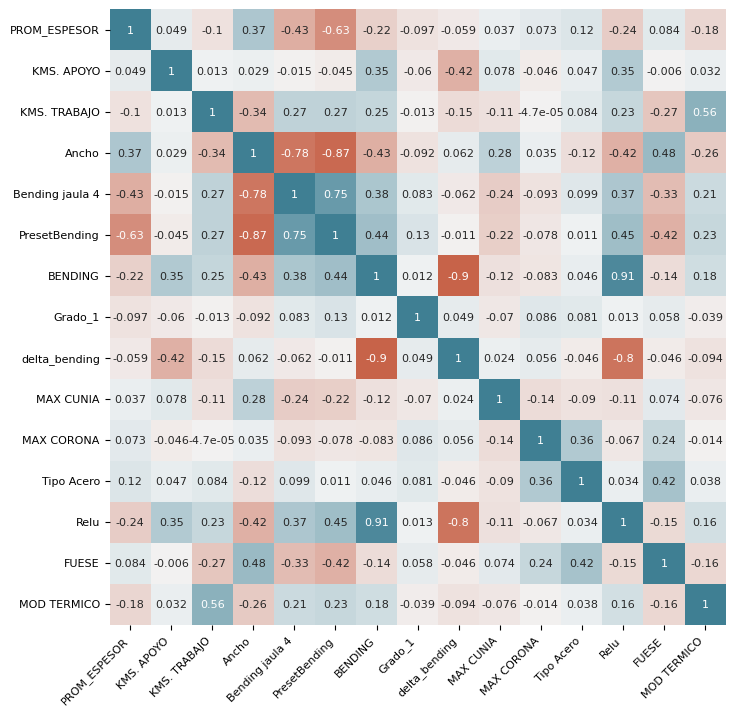

In [5]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = features.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(20)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

In [6]:
x=features.drop(ref)
y=x['BENDING']

x=x.drop('PresetBending', axis = 'columns')
x=x.drop('BENDING', axis = 'columns')
x=x.drop('Grado_1', axis = 'columns')
x=x.drop('delta_bending', axis = 'columns')
x=x.drop('MAX CUNIA', axis = 'columns')
x=x.drop('MAX CORONA', axis = 'columns')
x=x.drop('Tipo Acero', axis = 'columns')
x=x.drop('Relu', axis = 'columns')
#x=x.drop('FUESE', axis = 'columns')


#y=features['BENDING']

X_train, X_test, y_train, y_test = train_test_split(
                                        x,
                                        y,
                                        train_size   = 0.97,
                                        random_state = 1234,
                                        shuffle      = True
                                    )


In [7]:
model = LinearRegression()

In [8]:
model.fit(X_train, y_train)

LinearRegression()

In [9]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [10]:
print("Resultados en los datos de entrenamiento")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, Y_train_pred))))
print('  R2: {}'.format(r2_score(y_train, Y_train_pred)))
print('')
print("Resultados en los datos de validacion")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, Y_test_pred))))
print('  R2: {}'.format(r2_score(y_test, Y_test_pred)))

Resultados en los datos de entrenamiento
  RMSE: 19.55499839890459
  R2: 0.3400360251703609

Resultados en los datos de validacion
  RMSE: 19.09253951062223
  R2: 0.37135088595002297


In [11]:
print('w = ' + str(model.coef_) + ', b = ' + str(model.intercept_))

w = [-3.43783773  0.00534397  0.11599438 -0.04035434  0.06241634  0.04642817
  0.01205002], b = -4.036729394154133


#### XGBoost

In [12]:
xgb_r = xgb.XGBRegressor(
                  n_estimators = 5000,
                  learning_rate = 0.02,
                  max_depth = 5,
                   )

In [13]:
# Fitting the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [14]:
pred = xgb_r.predict(X_test)

In [15]:
Y_train_pred = xgb_r.predict(X_train)
Y_test_pred = xgb_r.predict(X_test)

In [16]:
print("Resultados en los datos de entrenamiento")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(y_train, Y_train_pred))))
print('  R2: {}'.format(r2_score(y_train, Y_train_pred)))
print('')
print("Resultados en los datos de validacion")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, Y_test_pred))))
print('  R2: {}'.format(r2_score(y_test, Y_test_pred)))

Resultados en los datos de entrenamiento
  RMSE: 10.61081574902369
  R2: 0.8056868434862381

Resultados en los datos de validacion
  RMSE: 13.948504729133166
  R2: 0.6644662429053227


#### Estadisticas de variable Relu

In [17]:
print("Resultados estadisticos de Relu")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(features['BENDING'], features['Relu']))))
print('  R2: {}'.format(r2_score(features['BENDING'], features['Relu'])))

Resultados estadisticos de Relu
  RMSE: 10.473618988084194
  R2: 0.8108842679749093


In [18]:
X_test

,PROM_ESPESOR,KMS. APOYO,KMS. TRABAJO,Ancho,Bending jaula 4,FUESE,MOD TERMICO
5084,0.656,959.0,15.0,905.0,43.366253,112.783,40.392131
1240,1.272,116.0,71.0,1035.0,5.668334,133.316,50.442035
29851,0.705,600.0,17.0,774.0,55.743380,142.810,37.666904
788,0.854,3614.0,48.0,940.0,18.961350,149.858,49.360986
22145,1.271,1973.0,29.0,1540.0,-42.637519,235.451,40.452103
...,...,...,...,...,...,...,...
10455,1.626,628.0,81.0,1221.0,-28.711076,179.786,42.189548
15792,1.625,5757.0,44.0,1040.0,-18.198799,118.933,43.446114
13580,0.711,1903.0,42.0,1048.0,27.086472,208.933,47.771070
20955,1.269,1047.0,55.0,1338.0,-16.542671,214.569,26.970979


In [19]:

valor_=test1.drop('PresetBending', axis = 'columns')
valor_=valor_.drop('BENDING', axis = 'columns')
valor_=valor_.drop('Grado_1', axis = 'columns')
valor_=valor_.drop('delta_bending', axis = 'columns')
valor_=valor_.drop('MAX CUNIA', axis = 'columns')
valor_=valor_.drop('MAX CORONA', axis = 'columns')
valor_=valor_.drop('Tipo Acero', axis = 'columns')
valor_=valor_.drop('Relu', axis = 'columns')
#valor_=valor_.drop('FUESE', axis = 'columns')
valor_=valor_.drop('TIEMPO', axis = 'columns')
valor_=valor_.drop('COD DEFECTO', axis = 'columns')




valor_.head()

,PROM_ESPESOR,KMS. APOYO,KMS. TRABAJO,Ancho,Bending jaula 4,FUESE,MOD TERMICO
1023,1.632,4103,3,1543.0,-45.065810,237.429,25.605929
1024,1.525,4105,4,1535.0,-46.673471,235.123,28.365469
1025,1.522,4106,5,1535.0,-43.370965,233.886,30.727961
1026,1.524,4108,7,1535.0,-46.334769,248.286,33.048856
1027,1.523,4109,8,1535.0,-46.364169,248.547,35.006302


In [20]:
valor_estimado = xgb_r.predict(valor_)
test1.insert(8, 'Valor Estimado', valor_estimado)

In [28]:
features['Tipo Acero'].unique()

array([183., 214., 172., 169., 191., 184., 370., 198., 173., 235., 338.,
       306., 403., 166., 393., 130.])

In [22]:
print("Resultados estadisticos de Relu")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(test1['BENDING'], test1['Relu']))))
print('  R2: {}'.format(r2_score(test1['BENDING'], test1['Relu'])))

Resultados estadisticos de Relu
  RMSE: 10.129799802399713
  R2: 0.7510503054554134


In [23]:
print("Resultados estadisticos de estimado")
print('  RMSE: {}'.format(np.sqrt(mean_squared_error(test1['BENDING'], test1['Valor Estimado']))))
print('  R2: {}'.format(r2_score(test1['BENDING'], test1['Valor Estimado'])))

Resultados estadisticos de estimado
  RMSE: 16.741853640092145
  R2: 0.31998740782249924
